In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import scipy.signal as signal
from scipy.signal import get_window
from scipy.fft import fft

sys.path.insert(0, '/home/leo_dacasi/Dokumente/summerofcode/ENFify/sources')
from ENF_preprocessing import generate_s_tone, generate_random_number
from ENF_frequency_phase_estimation import hilbert_instantaneous_freq, phase_estimation_DFT0


In [2]:
def scipy_IF_estimation(sig, fs):

    nperseg = 80
    freqs,times,stft = signal.stft(sig, fs=fs, nperseg=nperseg) # Apply STFT
    peak_freqs = [freqs[idx] for t in range(len(times)) if (idx := np.argmax(stft[:,t]))] # Extract peak for each point in time

    return peak_freqs

def freq_err(freq, estimate_freq):
    return np.abs(estimate_freq-freq)

def segmented_freq_estimation_DFT0(s_in, f_s, num_cycles, N_DFT, step_size):
    step_size = int(f_s // nominal_enf)  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    freqs = []
    for i in range(len(segments)):
        freq,_ = phase_estimation_DFT0(segments[i], f_s, N_DFT)
        freqs.append(freq)

    freqs = np.array(freqs)
    
    return freqs

def segmented_freq_estimation_DFT1(s_in, f_s, num_cycles, N_DFT, step_size):

    #step_size = f_s  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    freqs = []
    for i in range(len(segments)):
        freq = freq_estimation_DFT1(segments[i], f_s, N_DFT)
        freqs.append(freq)

    freqs = np.array(freqs)
    
    return freqs

def segmented_freq_estimation_hilbert(s_in, f_s, num_cycles, step_size):
    #step_size = f_s  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    freqs = []
    for i in range(len(segments)):
        freq = hilbert_instantaneous_freq(segments[i],f_s)
        freq = np.mean(freq)
        freqs.append(freq)

    freqs = np.array(freqs)
    
    return freqs
    
def segmented_scipy_freq_estimation(s_in, f_s, num_cycles, step_size):
    #step_size = int(f_s // nominal_enf)  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    freqs = []
    for i in range(len(segments)):
        freq = scipy_IF_estimation(segments[i],f_s)
        freq = np.mean(freq)
        freqs.append(freq)
    
    freqs = np.array(freqs)
    
    return freqs

def freq_estimation_DFT1(s_tone, Fs, N_DFT):

    ###......Estimate the frequency......###
    window_type = 'hann'
    M = len(s_tone)
    s_tone_unmodified = s_tone
    # Get the window type
    window = get_window(window_type, M-1)
    
    # Calculate the approx. first derivative of single tone
    s_tone_diff = Fs * np.diff(s_tone)
    s_tone = s_tone[1:]

    # Windowing
    s_tone_windowed = s_tone * window
    s_tone_diff_windowed = s_tone_diff * window

    # Zero-Padding of the signal
    s_tone_padded = np.pad(s_tone_windowed, (0, N_DFT - M), 'constant')
    s_tone_padded_diff = np.pad(s_tone_diff_windowed, (0, N_DFT - M), 'constant')

    # Calculate the DFT
    X = fft(s_tone_windowed,n=N_DFT)
    X_diff = fft(s_tone_diff_windowed,n=N_DFT)

    # Compute the amplitude spectrum and max. amplitude
    abs_X = np.abs(X)
    k_max = np.argmax(abs_X)
    abs_X_diff = np.abs(X_diff)

    # Estimated frequency of the single tone
    F_kmax = (np.pi * k_max) / (N_DFT * np.sin(np.pi * k_max/ N_DFT))
    f0_estimated = (F_kmax * abs_X_diff[k_max]) / (2 * np.pi * abs_X[k_max])

    return f0_estimated

[50.28008825 50.27770256 50.26992064 ... 49.99633133 49.99121511
 49.99417386]


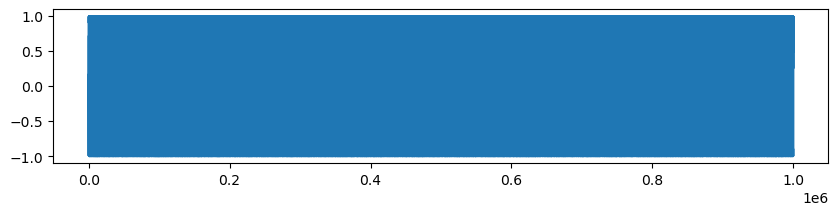

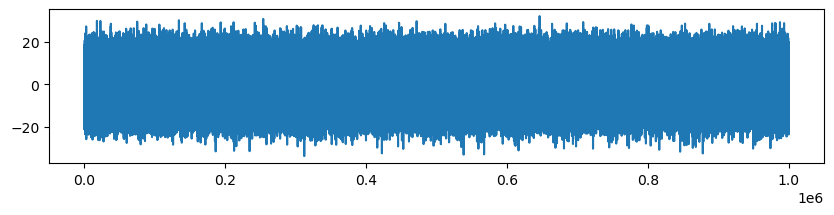

In [3]:
# Create synthetic ENF Signal and noised ENF Signal
pole = 0.99
GT_freq  = 50
mean_value = 50
std_deviation = 0.04
fs = 1000
phi0 = np.pi/4
period_len = int(fs/GT_freq)
n_samples = 1000*(50*period_len)

wgn = np.random.normal(0, 1, n_samples)
f_n = np.ones(n_samples) * GT_freq

for n in range(1, n_samples):
    f_n[n] = pole * f_n[n-1] + wgn[n]


f_n = f_n * std_deviation / np.std(f_n)
f_n = f_n + mean_value

n = np.arange(50*period_len)
n_num = 50*period_len


enf_sig = np.array([])
for i in range(1000):
    sig = np.array(np.cos((2 * np.pi * f_n[i*n_num:(n_num+n_num*i)] * n)/fs + phi0))
    enf_sig = np.concatenate((enf_sig,sig))
print(f_n)

plt.figure(figsize=(10,2))
plt.plot(enf_sig)
plt.show()

# Create noise 
n, s_n = generate_s_tone(fs, GT_freq, phi0, n_samples)
s_watts = s_n** 2

# Adding noise using target SNR
# Set a target SNR
target_snr_db = -20

# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(s_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)

# Calculate noise and convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)

# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(s_watts))

# Noise up the original signal
s_n_noised = enf_sig + noise_volts

plt.figure(figsize=(10,2))
plt.plot(s_n_noised)
plt.show()

In [4]:
# Synthetic ENF Signal
N_DFT = 20_000
fs = 1000
nominal_enf = 50
step_size = int(fs // nominal_enf)
num_cycles = 10
enf_sig = enf_sig
f_n = f_n

# DFT0
DFT0_freqs = segmented_freq_estimation_DFT0(enf_sig, fs, num_cycles, N_DFT, step_size)

sig_len = int(len(enf_sig)/len(DFT0_freqs))
DFT0_freqs_new = np.ones(len(enf_sig))

for l in range(len(DFT0_freqs)):
    DFT0_freqs_new[l*sig_len:(2*sig_len + 2*l*sig_len)] = DFT0_freqs[l]

freq_error_DFT0 = []
for i in range(len(DFT0_freqs_new)):
    freq_error_DFT0.append(freq_err(f_n[i], DFT0_freqs_new[i]))

print(f'Mean error DFT0: {np.mean(freq_error_DFT0)}')


# DFT1
DFT1_freqs = segmented_freq_estimation_DFT1(enf_sig, fs, num_cycles, N_DFT, step_size)

sig_len = int(len(enf_sig)/len(DFT1_freqs))
DFT1_freqs_new = np.ones(len(enf_sig))

for l in range(len(DFT1_freqs)):
    DFT1_freqs_new[l*sig_len:(2*sig_len + 2*l*sig_len)] = DFT1_freqs[l]

freq_error_DFT1 = []
for i in range(len(DFT1_freqs_new)):
    freq_error_DFT1.append(freq_err(f_n[i], DFT1_freqs_new[i]))

print(f'Mean error DFT1: {np.mean(freq_error_DFT1)}')


# Hilbert Segments
Hilbert_freqs = segmented_freq_estimation_hilbert(enf_sig, fs, num_cycles, step_size)
new_freqs_hilbert = np.ones(len(enf_sig))

for l in range(len(Hilbert_freqs)):
    new_freqs_hilbert[l*sig_len:(2*sig_len + 2*l*sig_len)] = Hilbert_freqs[l]

freq_error_hilbert = []
for i in range(len(new_freqs_hilbert)):
    freq_error_hilbert.append(freq_err(f_n[i],new_freqs_hilbert[i]))

print(f'Mean error Hilbert Segments: {np.mean(freq_error_hilbert)}')

# Hilbert
Hilbert_freqs = hilbert_instantaneous_freq(enf_sig, fs)

freq_error = []
for i in range(len(enf_sig)):
    freq_error.append(freq_err(f_n[i],Hilbert_freqs[i]))

print(f'Mean error Hilbert: {np.mean(freq_error)}')

# Scipy
scipy_freqs = segmented_scipy_freq_estimation(enf_sig, fs, num_cycles, step_size)
new_freqs_scipy = np.ones(len(enf_sig))

for l in range(len(scipy_freqs)):
    new_freqs_scipy[l*sig_len:(2*sig_len + 2*l*sig_len)] = scipy_freqs[l]

freq_error_scipy = []
for i in range(len(new_freqs_hilbert)):
    freq_error_scipy.append(freq_err(f_n[i], new_freqs_scipy[i]))

print(f'Mean error Scipy: {np.mean(freq_error_scipy)}')

Mean error DFT0: 0.18499361203696457
Mean error DFT1: 0.17236662108110082
Mean error Hilbert Segments: 0.03827025116110142
Mean error Hilbert: 1.4889589773567706
Mean error Scipy: 0.1306750461451849


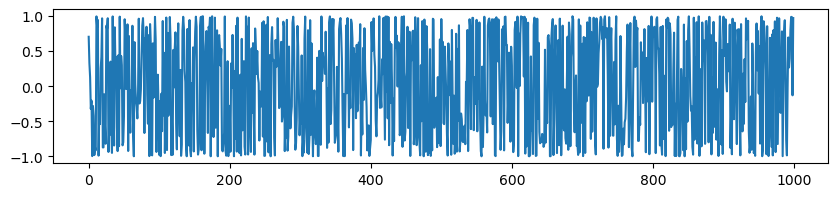

Mean error DFT0: 181.67243
Mean error DFT1: 181.63132785202993
Mean error Hilbert Segments: 127.88062585442889
Mean error Hilbert: 211.08077245936997


In [48]:
# Generate random signal
n_samples = 1000
fs = 1000
phi0 = np.pi/4
random_signal = []
random_freqs = []
n = np.arange(n_samples)

for i in range(n_samples):
    random_freq = generate_random_number(20, 80, 2)
    random_freqs.append(random_freq)
    random_signal.append(np.cos((2 * np.pi * random_freq * n[i])/fs + phi0))

plt.figure(figsize=(10,2))
plt.plot(random_signal)
plt.show()

# Random Signal
N_DFT = 20_000
nominal_enf = 50
step_size = int(fs // nominal_enf)
num_cycles = 10

# DFT0
DFT0_freqs = segmented_freq_estimation_DFT0(random_signal, fs, num_cycles, N_DFT, step_size)

sig_len = int(len(random_signal)/len(DFT0_freqs))
DFT0_freqs_new = np.ones(len(random_freqs))

for l in range(len(DFT0_freqs)):
    DFT0_freqs_new[l*sig_len:(2*sig_len + 2*l*sig_len)] = DFT0_freqs[l]

freq_error_DFT0 = []
for i in range(len(DFT0_freqs_new)):
    freq_error_DFT0.append(freq_err(random_freqs[i], DFT0_freqs_new[i]))

print(f'Mean error DFT0: {np.mean(freq_error_DFT0)}')


# DFT1
DFT1_freqs = segmented_freq_estimation_DFT1(random_signal, fs, num_cycles, N_DFT, step_size)

sig_len = int(len(random_signal)/len(DFT1_freqs))
DFT1_freqs_new = np.ones(len(random_freqs))

for l in range(len(DFT1_freqs)):
    DFT1_freqs_new[l*sig_len:(2*sig_len + 2*l*sig_len)] = DFT1_freqs[l]

freq_error_DFT1 = []
for i in range(len(DFT1_freqs_new)):
    freq_error_DFT1.append(freq_err(random_freqs[i], DFT1_freqs_new[i]))

print(f'Mean error DFT1: {np.mean(freq_error_DFT1)}')


# Hilbert Segments
Hilbert_freqs = segmented_freq_estimation_hilbert(random_signal, fs, num_cycles, step_size)
new_freqs_hilbert = np.ones(len(random_freqs))

for l in range(len(Hilbert_freqs)):
    new_freqs_hilbert[l*sig_len:(2*sig_len + 2*l*sig_len)] = Hilbert_freqs[l]

freq_error_hilbert = []
for i in range(len(new_freqs_hilbert)):
    freq_error_hilbert.append(freq_err(random_freqs[i], new_freqs_hilbert[i]))

print(f'Mean error Hilbert Segments: {np.mean(freq_error_hilbert)}')

# Hilbert
Hilbert_freqs = hilbert_instantaneous_freq(random_signal, fs)

freq_error = []
for i in range(len(random_freqs)):
    freq_error.append(freq_err(random_freqs[i], Hilbert_freqs[i]))

print(f'Mean error Hilbert: {np.mean(freq_error)}')
